In [1]:
from __future__ import print_function, division
%run ../basics.ipynb

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['show_config']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Loading BokehJS ...

Using Theano backend.


In [2]:
df = pd.read_csv('../data/learning_resources.csv')
display(df.head(2))
tags = pd.read_csv('../data/tags.csv')
display(tags.head(2))

df['tags'] = df['id'].apply(lambda x: (' '.join(tags[tags['resource_id'] == x]['concept_tag'].values.tolist())).strip())

print(df.columns)
print(df.count()/len(df)*100)
df.head(2)

,id,source_id,title,subtitle,description,short_description,syllabus,url,slug,difficulty,...,available,end_date,typical_learning_time,rating,price,new,language,format,license,venue
0,https://www.udacity.com/course/intro-to-comput...,cs101,Intro to Computer Science,Build a Search Engine & a Social Network,In this introduction to computer programming c...,Learn key computer science concepts in this in...,###Lesson 1: How to Get Started\n\n- Interview...,https://www.udacity.com/course/intro-to-comput...,intro-to-computer-science--cs101,beginner,...,NaN,NaN,3months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity
1,https://www.udacity.com/course/ab-testing--ud2...,ud257,A/B Testing,Online Experiment Design and Analysis,This course will cover the design and analysis...,This course will cover the design and analysis...,### Lesson 1: Overview of A/B Testing\nThis le...,https://www.udacity.com/course/ab-testing--ud2...,ab-testing--ud257,intermediate,...,NaN,NaN,1months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity


,resource_id,concept_tag
0,https://www.udacity.com/course/ab-testing--ud2...,video_lecture
1,https://www.udacity.com/course/ab-testing--ud2...,in_depth


Index([u'id', u'source_id', u'title', u'subtitle', u'description',
       u'short_description', u'syllabus', u'url', u'slug', u'difficulty',
       u'created', u'date_modified', u'date_published', u'available',
       u'end_date', u'typical_learning_time', u'rating', u'price', u'new',
       u'language', u'format', u'license', u'venue', u'tags'],
      dtype='object')
id                       100.000000
source_id                 39.521640
title                     99.886105
subtitle                  13.553531
description               65.148064
short_description         29.384966
syllabus                   5.580866
url                      100.000000
slug                      77.676538
difficulty                19.248292
created                   26.651481
date_modified             21.753986
date_published            21.184510
available                 21.640091
end_date                   1.366743
typical_learning_time     19.248292
rating                    10.136674
price            

,id,source_id,title,subtitle,description,short_description,syllabus,url,slug,difficulty,...,end_date,typical_learning_time,rating,price,new,language,format,license,venue,tags
0,https://www.udacity.com/course/intro-to-comput...,cs101,Intro to Computer Science,Build a Search Engine & a Social Network,In this introduction to computer programming c...,Learn key computer science concepts in this in...,###Lesson 1: How to Get Started\n\n- Interview...,https://www.udacity.com/course/intro-to-comput...,intro-to-computer-science--cs101,beginner,...,NaN,3months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity,video_lecture project overview computer_scienc...
1,https://www.udacity.com/course/ab-testing--ud2...,ud257,A/B Testing,Online Experiment Design and Analysis,This course will cover the design and analysis...,This course will cover the design and analysis...,### Lesson 1: Overview of A/B Testing\nThis le...,https://www.udacity.com/course/ab-testing--ud2...,ab-testing--ud257,intermediate,...,NaN,1months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity,video_lecture in_depth project data_collection...


In [29]:
class CLF(object):
    def __init__(self, n_topics=20, tag_vec_max_df=None, tag_vec_min_df=None, **kwargs):
        
        self.tag_vectorizer = CountVectorizer(max_df=.3 if tag_vec_max_df is None else tag_vec_max_df,
                                              min_df=0 if tag_vec_min_df is None else tag_vec_min_df)
        self.kwargs = kwargs
        self.n_neighbors = 1
        self.knn = KNeighborsClassifier(n_neighbors=self.n_neighbors, n_jobs=-1)
        self.y = None

    def fit(self, X):
        orig_X = X.copy()
        X = self.vectorize(X, fit=True)
        self.knn.fit(X, X)
        self.y = X
        
    def predict(self, X):
        X = self.vectorize(X, fit=False)
        dists, neighs_idx = map(np.array, 
                                self.knn.kneighbors(X=X, n_neighbors=self.n_neighbors + 1, return_distance=True))
        i = list()
        d = list()
        dist_0 = 0
        dist_1 = 0
        for di, nidx in zip(dists, neighs_idx):
            if np.isclose(di[0], 0.):
                d.append(di[1:])
                i.append(nidx[1:])
                dist_0 += 1
            else:
                d.append(di[:-1])
                i.append(nidx[:-1])
                dist_1 += 1
        print('dist zero:', dist_0)
        print('dist larger zero:', dist_1)
        dists = np.array(d)
        neighs_idx = np.array(i)
        assert dists.shape[1] == self.n_neighbors and neighs_idx.shape[1] == self.n_neighbors
        print('knn querry distance distribution')
        for i in range(dists.shape[1]):
            plt.title('neighbors idx: ' + str(i+1))
            sns.distplot(np.array(dists[:, i]).ravel())
            plt.show()
        tar_shape = (neighs_idx.shape[0], neighs_idx.shape[1], self.y.shape[1])
        print('tar shape:', tar_shape)
        preds = np.array(self.y)[np.array(neighs_idx).flatten(), :].reshape(tar_shape).astype('float')
        preds = preds.mean(axis=1)
        assert preds.shape[0] == X.shape[0] and preds.shape[1] == self.y.shape[1]
        return preds
    
    def vectorize(self, y, fit=False):
        if fit:
            y = y.fillna(' ')
            y = self.tag_vectorizer.fit_transform(y.values)
            if self.tag_vectorizer.stop_words_:
                print('ignored tags:')
                print(' ,'.join(self.tag_vectorizer.stop_words_))
            print('considered tags: (tag, resources tagged in %)')
            print(' ,'.join(map(str, sorted(zip(self.tag_vectorizer.get_feature_names(), 
                              np.array(y.sum(axis=0)).flatten()/y.shape[0]*100, 
                              np.array(y.sum(axis=0)).flatten()), key=itemgetter(1), reverse=True))))
        else:
            y = self.tag_vectorizer.transform(y.values)
        y = (y > 0).astype('float').todense()
        print('y shape', y.shape)
        return y
    
    def get_tag_names(self):
        return self.tag_vectorizer.get_feature_names()

In [30]:
clf = CLF(tag_vec_min_df=5)
print('# resources:', len(df))
print('orig len:', len(df))
tagged_df = df[df['tags'].apply(lambda x: len(x.strip())) > 0]
print('tagged resources:', len(tagged_df))
clf.fit(tagged_df['tags'])
#clf.plot_word_and_tag_clouds(df[['title', 'subtitle', 'description', 'syllabus']], df['tags'])

# resources: 878
orig len: 878
tagged resources: 872
ignored tags:
cancer ,programming_tool ,proteomics ,graph_database ,biology ,data_science_process ,electronic_health_record ,topic_model ,text_data ,galaxy ,fmri ,xml ,video_lecture ,gis ,nosql ,seminar ,panel_discussion ,functional_programming_languages ,json ,book ,tutorial ,structural_biology ,mobile_devices ,streaming_data ,conference ,classification ,literature ,workflow ,strategic_talk ,javascript ,supervised_learning ,neuroimaging ,degree_program ,decision_tree ,precision_medicine ,in_person_workshop_series ,sql ,neuroscience ,panel ,career_advice ,drug_discovery ,linear_algebra ,association_rule_learning ,clinical_research ,html ,information_retrieval ,optimization ,security ,public_health ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'mooc', 24.88532110091743, 217) ,(u'overview', 22.362385321100916, 195) ,(u'in_depth', 22.018348623853214, 192) ,(u'machine_learning', 19.610091743119266, 171) ,(u'bd2k', 12

y shape (872, 62)
dist zero: 872
dist larger zero: 0
knn querry distance distribution


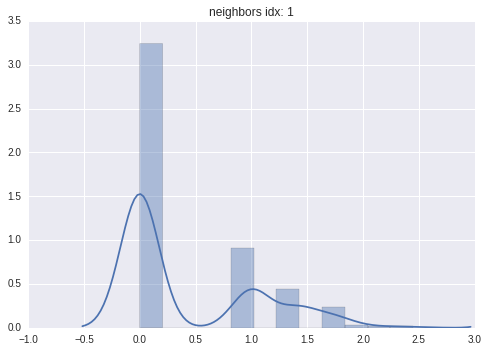

tar shape: (872, 1, 62)
(872, 62)


In [31]:
y_pred = np.array(clf.predict(tagged_df['tags']))
print(y_pred.shape)

In [32]:
y_true = clf.vectorize(tagged_df['tags'])
tags = np.array(clf.get_tag_names())

print(classification_report(y_true, y_pred > .5, target_names=tags))

y shape (872, 62)
                               precision    recall  f1-score   support

            archive_available       0.97      1.00      0.99        36
      artificial_intelligence       1.00      0.83      0.91         6
                         bd2k       1.00      0.92      0.96       107
                     big_data       0.89      0.79      0.84        73
           business_analytics       1.00      0.93      0.96        58
                   case_study       0.91      0.53      0.67        38
                    causality       0.94      1.00      0.97        15
                   clustering       0.71      0.56      0.63         9
             code_walkthrough       0.92      1.00      0.96        12
             computer_science       0.00      0.00      0.00         6
                data_cleaning       0.71      0.36      0.48        14
              data_collection       0.84      0.55      0.67        38
             data_integration       0.89      0.54      0.

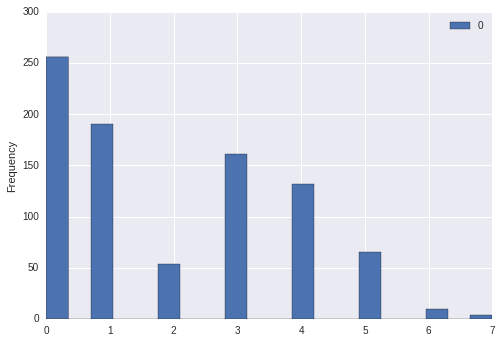

In [25]:
pd.DataFrame((y_pred > 0.5).sum(axis=1)).plot(kind='hist', bins=20)

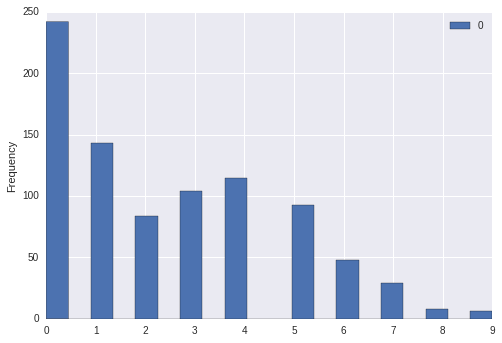

In [26]:
pd.DataFrame((y_true > 0.5).sum(axis=1)).plot(kind='hist', bins=20)

  0%|          | 0/10 [00:00<?, ?it/s]

# resources: 878
tagged resources: 872
ignored tags:
graph_data ,nosql ,programming_tool ,proteomics ,natural_language_processing ,ensemble_learning ,information_retrieval ,fmri ,xml ,cancer ,seminar ,dimensionality_reduction ,panel_discussion ,functional_programming_languages ,json ,book ,tutorial ,structural_biology ,mobile_devices ,streaming_data ,conference ,classification ,literature ,workflow ,strategic_talk ,supervised_learning ,neuroimaging ,degree_program ,decision_tree ,precision_medicine ,in_person_workshop_series ,sql ,neuroscience ,panel ,electronic_health_record ,career_advice ,drug_discovery ,linear_algebra ,association_rule_learning ,clinical_research ,recommender_system ,optimization ,security ,public_health ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'biology', 34.810126582278485, 275) ,(u'data_science_process', 33.291139240506325, 263) ,(u'video_lecture', 31.0126582278481, 245) ,(u'overview', 21.645569620253163, 171) ,(u'machine_learning', 20.6

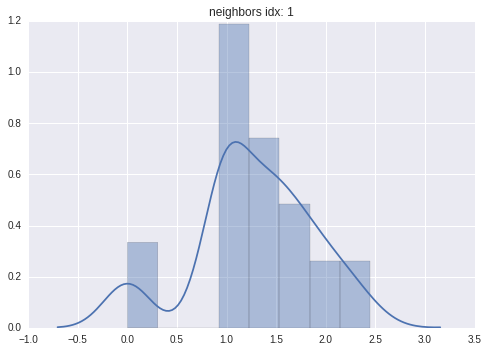

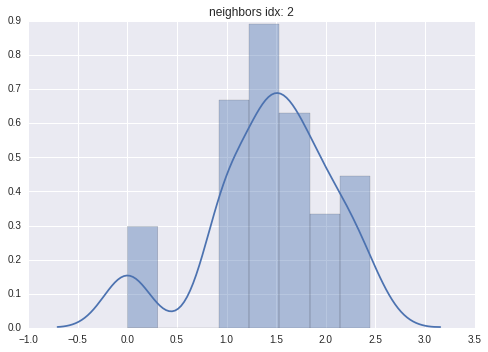

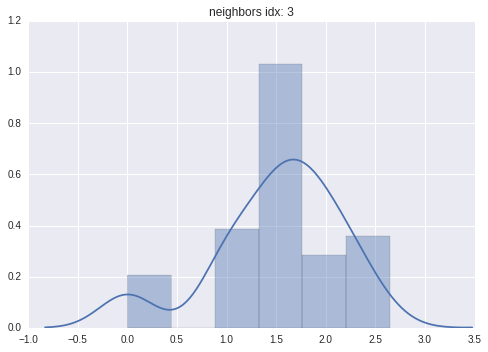

 10%|█         | 1/10 [00:01<00:13,  1.45s/it]

tar shape: (88, 3, 60)
y shape (88, 60)
ignored tags:
cancer ,proteomics ,graph_database ,ensemble_learning ,engineering ,topic_model ,text_data ,galaxy ,fmri ,xml ,gis ,nosql ,seminar ,dimensionality_reduction ,panel_discussion ,functional_programming_languages ,json ,book ,tutorial ,structural_biology ,mobile_devices ,mathematics ,artificial_intelligence ,computer_science ,conference ,classification ,literature ,workflow ,strategic_talk ,javascript ,supervised_learning ,neuroimaging ,degree_program ,decision_tree ,precision_medicine ,in_person_workshop_series ,sql ,neuroscience ,streaming_data ,panel ,electronic_health_record ,career_advice ,drug_discovery ,linear_algebra ,association_rule_learning ,clinical_research ,html ,information_retrieval ,recommender_system ,optimization ,security ,public_health ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'video_lecture', 39.620253164556964, 313) ,(u'biology', 34.683544303797468, 274) ,(u'data_science_process', 33.67088

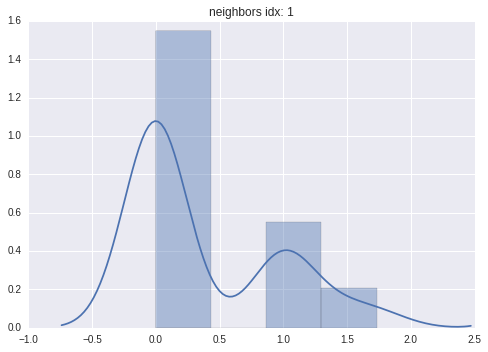

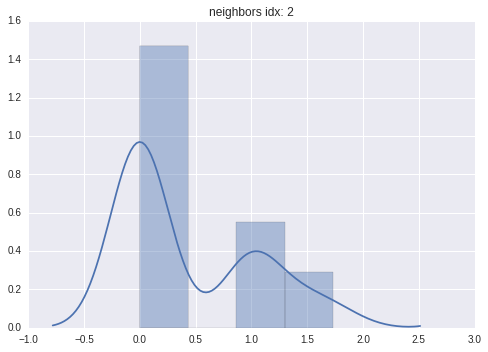

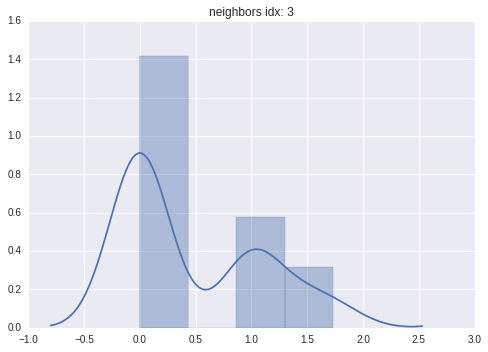

 20%|██        | 2/10 [00:02<00:10,  1.37s/it]

tar shape: (88, 3, 58)
y shape (88, 58)
ignored tags:
cancer ,programming_tool ,proteomics ,graph_database ,electronic_health_record ,topic_model ,text_data ,galaxy ,fmri ,xml ,gis ,nosql ,seminar ,panel_discussion ,functional_programming_languages ,json ,book ,tutorial ,structural_biology ,mobile_devices ,mathematics ,computer_science ,conference ,classification ,literature ,workflow ,strategic_talk ,javascript ,supervised_learning ,neuroimaging ,degree_program ,decision_tree ,precision_medicine ,in_person_workshop_series ,sql ,neuroscience ,streaming_data ,panel ,career_advice ,drug_discovery ,linear_algebra ,association_rule_learning ,clinical_research ,html ,information_retrieval ,optimization ,security ,public_health ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'video_lecture', 41.97218710493047, 332) ,(u'biology', 34.766118836915297, 275) ,(u'data_science_process', 34.007585335018966, 269) ,(u'mooc', 27.43362831858407, 217) ,(u'overview', 24.652338811630848,

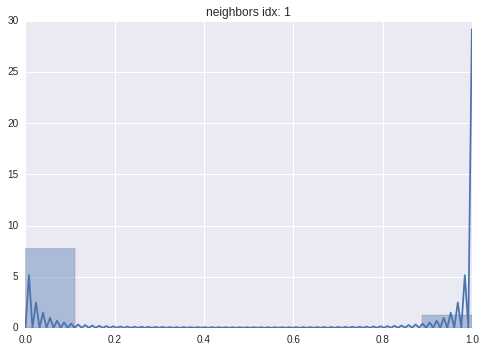

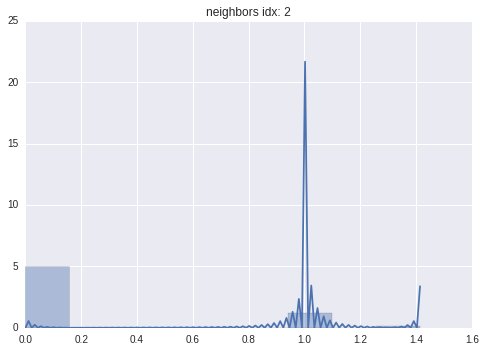

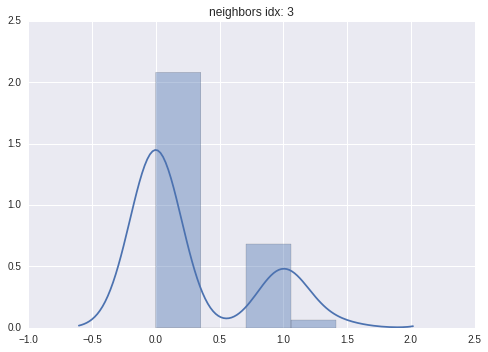

 30%|███       | 3/10 [00:03<00:09,  1.30s/it]

tar shape: (87, 3, 63)
y shape (87, 63)
ignored tags:
cancer ,programming_tool ,proteomics ,graph_database ,ensemble_learning ,engineering ,topic_model ,text_data ,galaxy ,fmri ,xml ,gis ,nosql ,seminar ,panel_discussion ,functional_programming_languages ,json ,book ,tutorial ,structural_biology ,streaming_data ,conference ,classification ,literature ,workflow ,strategic_talk ,javascript ,supervised_learning ,neuroimaging ,degree_program ,decision_tree ,precision_medicine ,in_person_workshop_series ,sql ,neuroscience ,panel ,electronic_health_record ,career_advice ,drug_discovery ,association_rule_learning ,clinical_research ,html ,information_retrieval ,optimization ,security ,public_health ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'video_lecture', 37.294563843236411, 295) ,(u'biology', 34.513274336283182, 273) ,(u'data_science_process', 33.501896333754736, 265) ,(u'mooc', 22.756005056890015, 180) ,(u'overview', 22.376738305941846, 177) ,(u'in_depth', 22.12389

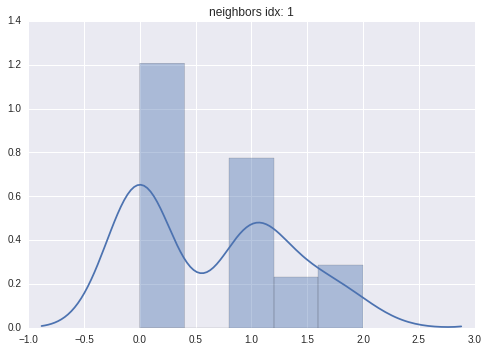

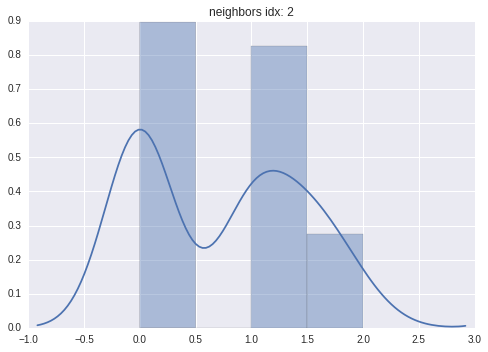

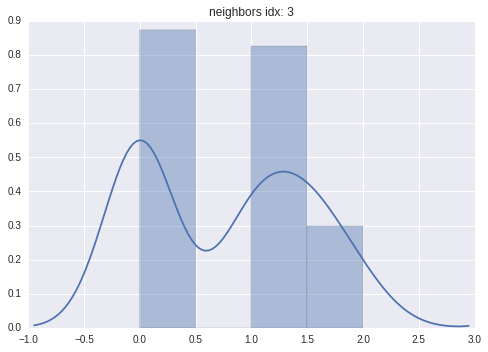

 40%|████      | 4/10 [00:05<00:07,  1.33s/it]

tar shape: (87, 3, 63)
y shape (87, 63)
ignored tags:
cancer ,programming_tool ,proteomics ,graph_database ,electronic_health_record ,topic_model ,text_data ,education ,galaxy ,fmri ,xml ,gis ,nosql ,seminar ,dimensionality_reduction ,panel_discussion ,functional_programming_languages ,json ,book ,tutorial ,mobile_devices ,streaming_data ,conference ,classification ,literature ,workflow ,strategic_talk ,javascript ,supervised_learning ,neuroimaging ,degree_program ,decision_tree ,precision_medicine ,in_person_workshop_series ,sql ,neuroscience ,panel ,career_advice ,drug_discovery ,linear_algebra ,association_rule_learning ,clinical_research ,html ,information_retrieval ,recommender_system ,optimization ,security ,public_health ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'biology', 34.513274336283182, 273) ,(u'data_science_process', 32.996207332490521, 261) ,(u'video_lecture', 32.616940581542352, 258) ,(u'machine_learning', 20.353982300884958, 161) ,(u'mooc', 20.

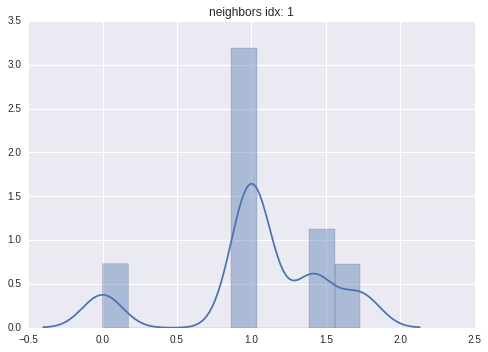

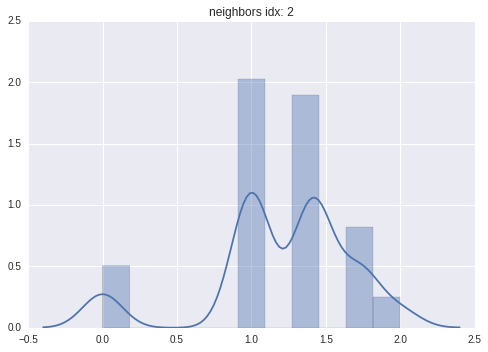

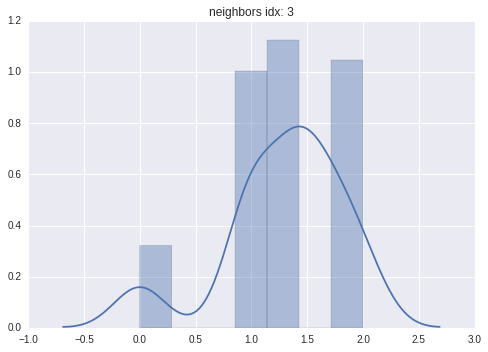

 50%|█████     | 5/10 [00:06<00:06,  1.29s/it]

tar shape: (87, 3, 61)
y shape (87, 61)
ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,engineering ,topic_model ,text_data ,galaxy ,fmri ,xml ,gis ,nosql ,seminar ,panel_discussion ,json ,book ,tutorial ,structural_biology ,mobile_devices ,streaming_data ,conference ,workflow ,javascript ,supervised_learning ,neuroimaging ,degree_program ,precision_medicine ,in_person_workshop_series ,neuroscience ,drug_discovery ,linear_algebra ,association_rule_learning ,clinical_research ,html ,information_retrieval ,optimization ,security ,public_health
considered tags: (tag, resources tagged in %)
(u'data_science_process', 33.881163084702912, 268) ,(u'biology', 33.375474083438682, 264) ,(u'video_lecture', 32.743362831858406, 259) ,(u'mooc', 27.43362831858407, 217) ,(u'machine_learning', 20.101137800252843, 159) ,(u'in_depth', 19.469026548672566, 154) ,(u'overview', 19.216182048040455, 152) ,(u'bd2k', 13.02149178255373, 103) ,(u'probability_statistics', 10.493046

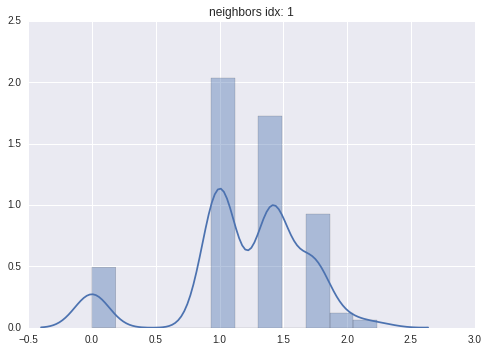

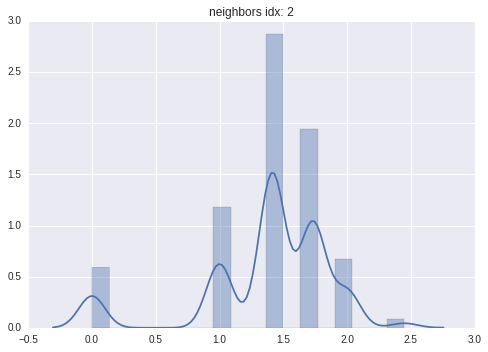

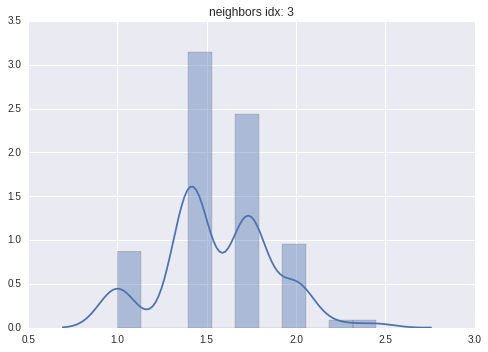

 60%|██████    | 6/10 [00:07<00:05,  1.28s/it]

tar shape: (87, 3, 62)
y shape (87, 62)
ignored tags:
cancer ,programming_tool ,proteomics ,graph_database ,electronic_health_record ,topic_model ,image_data ,text_data ,information_retrieval ,xml ,gis ,nosql ,seminar ,panel_discussion ,functional_programming_languages ,html ,galaxy ,structural_biology ,mobile_devices ,mathematics ,tutorial ,fmri ,classification ,literature ,strategic_talk ,javascript ,supervised_learning ,decision_tree ,precision_medicine ,sql ,neuroscience ,streaming_data ,panel ,career_advice ,drug_discovery ,linear_algebra ,association_rule_learning ,optimization ,security ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'video_lecture', 36.915297092288242, 292) ,(u'data_science_process', 33.375474083438682, 264) ,(u'biology', 32.869785082174459, 260) ,(u'mooc', 25.53729456384324, 202) ,(u'in_depth', 20.733249051833123, 164) ,(u'machine_learning', 20.227560050568901, 160) ,(u'overview', 18.204804045512009, 144) ,(u'probability_statistics', 10.2402

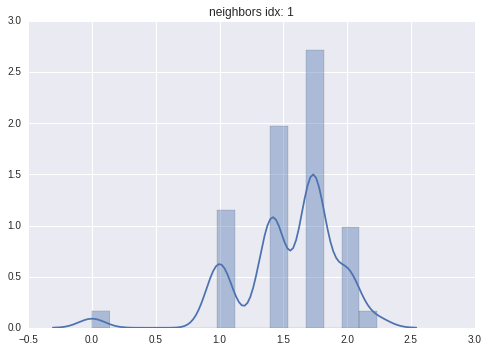

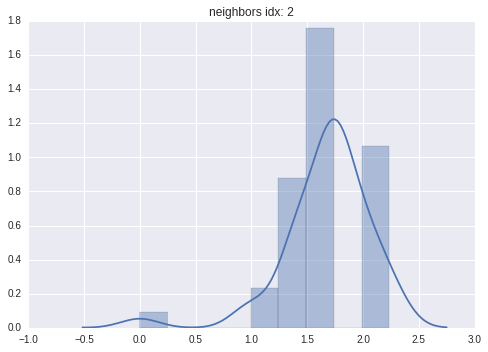

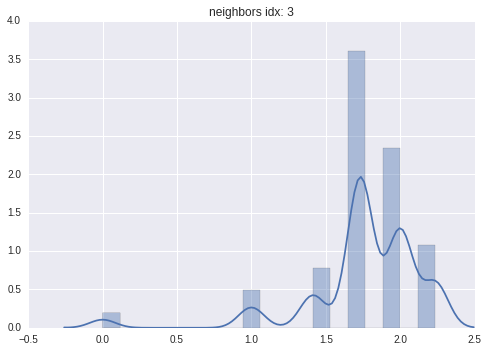

 70%|███████   | 7/10 [00:09<00:04,  1.35s/it]

tar shape: (87, 3, 61)
y shape (87, 61)
ignored tags:
cancer ,programming_tool ,proteomics ,graph_database ,electronic_health_record ,topic_model ,text_data ,galaxy ,fmri ,xml ,gis ,nosql ,seminar ,panel_discussion ,functional_programming_languages ,json ,book ,tutorial ,structural_biology ,mobile_devices ,streaming_data ,conference ,classification ,literature ,workflow ,strategic_talk ,javascript ,supervised_learning ,neuroimaging ,degree_program ,decision_tree ,precision_medicine ,in_person_workshop_series ,sql ,neuroscience ,panel ,career_advice ,linear_algebra ,association_rule_learning ,clinical_research ,html ,information_retrieval ,optimization ,security ,public_health ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'video_lecture', 41.719342604298355, 330) ,(u'mooc', 27.307206068268012, 216) ,(u'biology', 25.916561314791402, 205) ,(u'data_science_process', 25.410872313527182, 201) ,(u'in_depth', 23.261694058154237, 184) ,(u'overview', 23.261694058154237, 184)

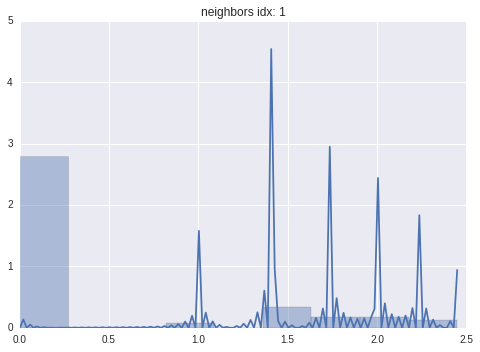

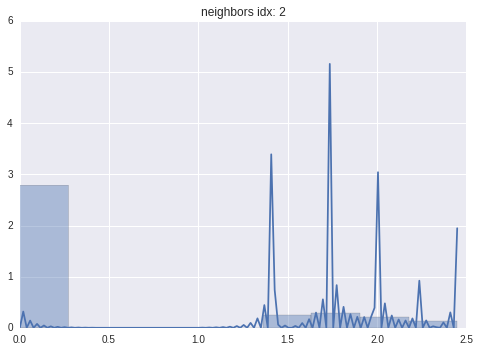

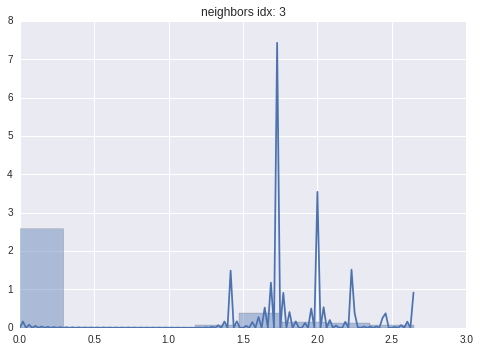

 80%|████████  | 8/10 [00:10<00:02,  1.30s/it]

tar shape: (87, 3, 65)
y shape (87, 65)
ignored tags:
cancer ,programming_tool ,proteomics ,graph_database ,electronic_health_record ,topic_model ,text_data ,galaxy ,fmri ,xml ,gis ,nosql ,seminar ,panel_discussion ,functional_programming_languages ,json ,book ,tutorial ,structural_biology ,mobile_devices ,streaming_data ,conference ,classification ,literature ,workflow ,strategic_talk ,javascript ,supervised_learning ,neuroimaging ,degree_program ,decision_tree ,precision_medicine ,in_person_workshop_series ,sql ,neuroscience ,panel ,career_advice ,drug_discovery ,linear_algebra ,association_rule_learning ,clinical_research ,html ,information_retrieval ,optimization ,security ,public_health ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'video_lecture', 41.97218710493047, 332) ,(u'mooc', 27.43362831858407, 217) ,(u'overview', 24.652338811630848, 195) ,(u'in_depth', 24.273072060682679, 192) ,(u'biology', 23.767383059418457, 188) ,(u'data_science_process', 23.0088495

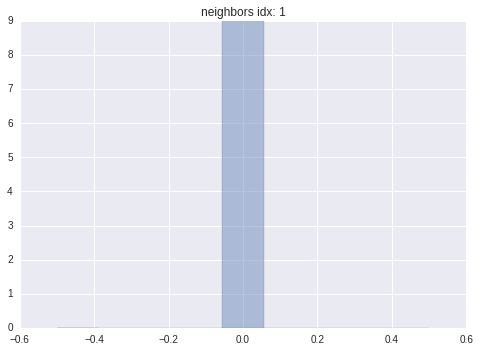

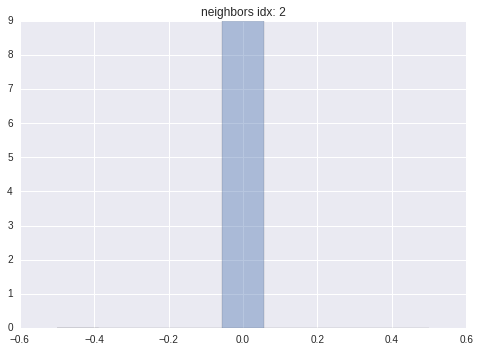

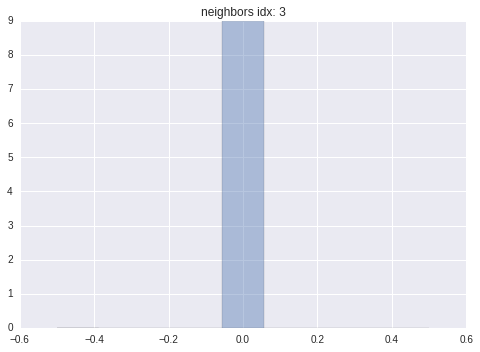

 90%|█████████ | 9/10 [00:11<00:01,  1.28s/it]

tar shape: (87, 3, 65)
y shape (87, 65)
ignored tags:
cancer ,programming_tool ,proteomics ,graph_database ,electronic_health_record ,topic_model ,text_data ,galaxy ,fmri ,xml ,gis ,nosql ,seminar ,panel_discussion ,functional_programming_languages ,json ,book ,tutorial ,structural_biology ,mobile_devices ,streaming_data ,conference ,classification ,literature ,workflow ,strategic_talk ,javascript ,supervised_learning ,neuroimaging ,degree_program ,decision_tree ,precision_medicine ,in_person_workshop_series ,sql ,neuroscience ,panel ,career_advice ,drug_discovery ,linear_algebra ,association_rule_learning ,clinical_research ,html ,information_retrieval ,optimization ,security ,public_health ,genetic_algorithm
considered tags: (tag, resources tagged in %)
(u'video_lecture', 41.97218710493047, 332) ,(u'mooc', 27.43362831858407, 217) ,(u'overview', 24.652338811630848, 195) ,(u'in_depth', 24.273072060682679, 192) ,(u'biology', 23.767383059418457, 188) ,(u'data_science_process', 23.0088495

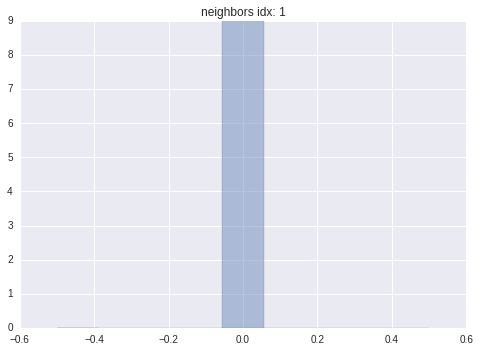

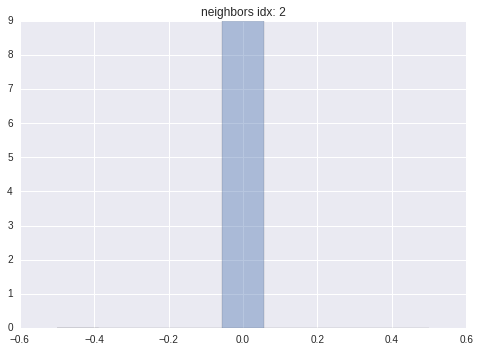

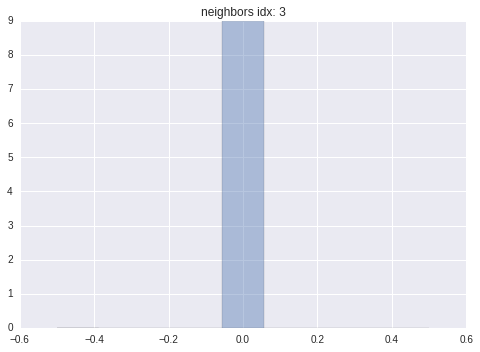

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]

tar shape: (87, 3, 65)
y shape (87, 65)


In [27]:
#%run ../basics.ipynb
print('# resources:', len(df))
print('tagged resources:', (df['tags'].apply(len) > 0).sum())
tag_idx = df[df['tags'].apply(len) > 0].index
all_idx = set(df.index)
all_y_pred = list()
all_y_true = list()
tag_names = list()
n_folds = 10

for train_idx, test_idx in tqdm(KFold(len(tag_idx), n_folds=n_folds), total=n_folds):
    test_idx = tag_idx[test_idx]
    train_idx = list(all_idx - set(test_idx))
    train_df = df.loc[train_idx].copy()
    test_df = df.loc[test_idx].copy()
    clf = CLF(tag_vec_min_df=5, tag_vec_max_df=1.)
    clf.fit(train_df['tags'])
    y_pred = clf.predict(test_df['tags'])
    y_true = clf.vectorize(test_df['tags'])
    # print('hamming loss:', hamming_loss(y_true, y_pred))
    all_y_pred.append(y_pred)
    all_y_true.append(y_true)
    tag_names.append(clf.get_tag_names())

In [28]:
all_tags = sorted(set([j for i in tag_names for j in i]))
tmp_all_y_true = list()
tmp_all_y_pred = list()
for y_true, y_pred, t_names in zip(all_y_true, all_y_pred, tag_names):
    tmp_y_t = np.zeros((y_true.shape[0], len(all_tags)))
    tmp_y_p = np.zeros((y_pred.shape[0], len(all_tags)))
    sorting = np.array([all_tags.index(i) for i in t_names])
    tmp_y_t[:, sorting] = y_true
    tmp_y_p[:, sorting] = y_pred
    tmp_all_y_true.extend([np.array(i).flatten() for i in tmp_y_t])
    tmp_all_y_pred.extend([np.array(i).flatten() for i in tmp_y_p])

#print('avg. roc auc score weighted by support:', roc_auc_score(np.array(tmp_all_y_true),
#                                                                   np.array(tmp_all_y_pred), average='weighted'))
#print('hamming loss:', hamming_loss(np.array(tmp_all_y_true), np.array(tmp_all_y_pred)))

for pred_th in [0.1, 0.5, 0.9]:
    #print('res shape:', all_y_true.shape)
    print(classification_report(np.array(tmp_all_y_true), np.array(tmp_all_y_pred) > pred_th, target_names=all_tags))
    

                               precision    recall  f1-score   support

            archive_available       0.71      0.47      0.57        36
      artificial_intelligence       1.00      0.50      0.67         2
                         bd2k       0.84      0.58      0.69       107
                     big_data       0.67      0.78      0.72        73
                      biology       0.94      0.96      0.95       275
           business_analytics       0.55      0.90      0.68        58
                   case_study       0.61      0.71      0.66        38
                    causality       0.83      1.00      0.91        15
                   clustering       1.00      0.78      0.88         9
             code_walkthrough       0.71      1.00      0.83        12
             computer_science       1.00      0.50      0.67         2
                data_cleaning       0.35      0.57      0.43        14
              data_collection       0.58      0.79      0.67        38
     